# PPO Training for Dermatology Triage Clinic

**Reinforcement Learning Summative Assignment**

This notebook trains a Proximal Policy Optimization (PPO) agent on the custom dermatology clinic triage environment.

## Workflow:
1. **Setup**: Mount Drive, install dependencies
2. **Environment**: Embed ClinicEnv code
3. **Configurations**: Load 10 PPO hyperparameter configs
4. **Quick Sweep**: Train all 10 configs for 50K steps each
5. **Analysis**: Identify best performing configuration
6. **Full Training**: Train best config with 5 seeds for 200K steps
7. **Evaluation**: Generate plots and performance metrics
8. **Export**: Save models and results to Google Drive

**Estimated Runtime**: 5-7 hours on Colab GPU


## 1. Setup: Mount Google Drive & Install Dependencies


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up project directory on Drive
import os
PROJECT_DIR = '/content/drive/MyDrive/RL_Summative'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models/ppo', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/logs/ppo', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/plots', exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Project directory: {PROJECT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Project directory: /content/drive/MyDrive/RL_Summative


In [ ]:
# Install required packages
# NOTE: numpy 1.26.4 is specified to avoid binary incompatibility with torch
# Install numpy FIRST, then restart runtime before importing any libraries
%pip install -q numpy==1.26.4
%pip install -q torch
%pip install -q gymnasium
%pip install -q stable-baselines3
%pip install -q sb3-contrib
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q pandas
%pip install -q tqdm
%pip install -q imageio

print("\n" + "="*60)
print("✓ All packages installed successfully!")
print("="*60)
print("\n⚠️  IMPORTANT: RESTART RUNTIME NOW")
print("Click 'Runtime' → 'Restart runtime' in the menu above")
print("Then run ALL cells again from the beginning")
print("="*60)


✓ All packages installed successfully!

⚠️  IMPORTANT: RESTART RUNTIME NOW
Click 'Runtime' → 'Restart runtime' in the menu above
Then run ALL cells again from the beginning


In [ ]:
# Import libraries
import gymnasium as gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from typing import Tuple, Dict, Any, Optional, List
from tqdm.notebook import tqdm
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 2. Embed ClinicEnv (Custom Gymnasium Environment)


In [ ]:
class ClinicEnv(gym.Env):
    """
    Clinic triage environment (vector-based).
    Obs: [age, duration, fever, infection, 8 symptom dims, room_avail, queue_len, time_of_day] (15,)
    Actions (Discrete 8): 0=doctor,1=nurse,2=remote,3=escalate,4=defer,5=idle,6=open_room,7=close_room
    """
    metadata = {"render_modes": ["rgb_array"], "render_fps": 6}

    def __init__(self, seed: int = 0, max_steps: int = 500):
        super().__init__()
        self.seed(seed)
        self.max_steps = max_steps
        # FIX: Changed shape from (14,) to (15,) to match the actual observation vector
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(15,), dtype=np.float32)
        self.action_space = spaces.Discrete(8)

        # internal state
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = []
        self.current_patient = None
        self.total_wait = 0.0
        self.last_render = None

        # reward tuning defaults
        self.wrong_penalty_base = -2.0
        self.severity_multiplier = {0:1.0, 1:1.2, 2:1.6, 3:2.2}
        self.resource_cost_scale = -0.02
        self.wait_penalty_scale = -0.01
        self.critical_fast_threshold = 5

        # Initialize directly
        self._reset_internal()

    def seed(self, seed=None):
        self._seed = seed
        random.seed(seed)
        np.random.seed(seed)
        return [seed]

    def _sample_patient(self) -> Dict[str, Any]:
        severity = int(np.random.choice([0,1,2,3], p=[0.4,0.35,0.2,0.05]))
        age_norm = float(np.clip(np.random.normal(0.5, 0.15), 0.0, 1.0))
        duration_norm = float(np.clip(np.random.exponential(0.5), 0.0, 1.0))
        fever_flag = 1.0 if (np.random.rand() < (0.05 + 0.2*severity)) else 0.0
        infection_flag = 1.0 if (np.random.rand() < (0.05 + 0.25*severity)) else 0.0
        base = 0.2 + 0.25*severity
        symptom_embed = np.clip(np.random.normal(loc=base, scale=0.08, size=(8,)), 0.0, 1.0)
        return {
            "severity": severity,
            "age_norm": age_norm,
            "duration_norm": duration_norm,
            "fever_flag": fever_flag,
            "infection_flag": infection_flag,
            "symptom_embed": symptom_embed,
            "wait_time": 0.0
        }

    def _form_observation(self, patient: Dict[str,Any]) -> np.ndarray:
        vec = [
            patient["age_norm"],
            patient["duration_norm"],
            patient["fever_flag"],
            patient["infection_flag"],
        ]
        vec += list(patient["symptom_embed"])
        vec += [
            1.0 if self.num_open_rooms > 0 else 0.0,
            np.clip(len(self.queue) / 10.0, 0.0, 1.0),
            np.clip(self.step_count / self.max_steps, 0.0, 1.0)
        ]
        # This vector has length 15 (4 + 8 + 3)
        return np.array(vec, dtype=np.float32)

    def _reset_internal(self):
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = [self._sample_patient() for _ in range(3)]
        self.current_patient = None
        self.total_wait = 0.0
        self._maybe_spawn_next()

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed(seed)
        self._reset_internal()
        obs = self._form_observation(self.current_patient)
        info = {}
        # Gym API: reset must return (obs, info)
        return obs, info

    def _maybe_spawn_next(self):
        if self.current_patient is None and len(self.queue) > 0:
            self.current_patient = self.queue.pop(0)
        elif self.current_patient is None:
            self.current_patient = self._sample_patient()

    def step(self, action: int):
        assert self.action_space.contains(action), "Invalid action"
        self.step_count += 1

        terminated = False
        truncated = False
        info: Dict[str,Any] = {}
        patient = self.current_patient
        reward = 0.0

        # correct action mapping
        if patient["severity"] == 0:
            correct_action = 2
        elif patient["severity"] == 1:
            correct_action = 1
        elif patient["severity"] == 2:
            correct_action = 0
        else:
            correct_action = 3

        # triage reward / penalty
        if action == correct_action:
            if patient["severity"] == 0:
                reward += 1.0
            elif patient["severity"] == 1:
                reward += 1.25
            elif patient["severity"] == 2:
                reward += 2.0
            else:
                reward += 3.0 if patient["wait_time"] < self.critical_fast_threshold else 2.0
        else:
            mult = self.severity_multiplier.get(patient["severity"], 1.0)
            reward += self.wrong_penalty_base * mult

        # action effects
        if action == 6:
            self.num_open_rooms += 1
        if action == 7 and self.num_open_rooms > 0:
            self.num_open_rooms -= 1
        if action == 4:
            patient["wait_time"] += 1.0
            self.queue.append(patient)
            self.current_patient = None
        else:
            self.current_patient = None

        # queue wait penalty increment
        wait_increment = 0.01 * len(self.queue)
        for p in self.queue:
            p["wait_time"] += 1.0
        self.total_wait += wait_increment
        reward += self.wait_penalty_scale * wait_increment

        # resource cost
        reward += self.resource_cost_scale * max(0, self.num_open_rooms)

        # clip reward
        reward = float(np.clip(reward, -6.0, 6.0))

        # spawn next patient
        self._maybe_spawn_next()

        obs = self._form_observation(self.current_patient)

        # Check termination
        if self.step_count >= self.max_steps:
            truncated = True

        info["current_severity"] = int(patient["severity"])
        info["correct_action"] = int(correct_action)
        info["num_open_rooms"] = int(self.num_open_rooms)
        info["queue_length"] = len(self.queue)
        info["triage_reward_component"] = float(reward)

        # Gym API: step must return (obs, reward, terminated, truncated, info)
        return obs, reward, terminated, truncated, info

    def render(self, mode="rgb_array") -> np.ndarray:
        H, W = 240, 360
        canvas = np.ones((H, W, 3), dtype=np.uint8) * 255
        sev = self.current_patient["severity"] if self.current_patient else 0
        sev_norm = sev / 3.0
        color = np.array([int(255 * sev_norm), int(180 * (1 - sev_norm)), 60], dtype=np.uint8)
        canvas[20:200, 20:60] = color
        q_len = len(self.queue)
        q_h = min(q_len * 15, 150)
        canvas[20:20+q_h, 80:100] = [80, 80, 255]
        r = self.num_open_rooms
        r_h = min(r * 20, 150)
        canvas[20:20+r_h, 120:140] = [50, 200, 50]
        sym = self.current_patient["symptom_embed"] if self.current_patient else np.zeros(8)
        for i, val in enumerate(sym):
            x0 = 160 + i*20
            height = int(120 * val)
            canvas[150-height:150, x0:x0+12] = [int(100+150*val), int(100*(1-val)), int(50)]
        self.last_render = canvas
        return canvas

## 3. Load PPO Configurations (10 Hyperparameter Sets)


In [ ]:
# Embedded PPO configurations (Optimized for High Entropy/Exploration)
PPO_CONFIGS = {
    "configs": [
      {
          "id": "ppo_01_baseline",
          "description": "Standard baseline PPO configuration",
          "learning_rate": 3e-4,
          "gamma": 0.99,
          "n_steps": 128,
          "batch_size": 64,
          "n_epochs": 3,
          "gae_lambda": 0.95,
          "clip_range": 0.2,
          "ent_coef": 0.0,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_02_high_epochs",
          "description": "Higher update epochs for stronger learning signal",
          "learning_rate": 1e-4,
          "gamma": 0.99,
          "n_steps": 256,
          "batch_size": 64,
          "n_epochs": 10,
          "gae_lambda": 0.95,
          "clip_range": 0.2,
          "ent_coef": 0.01,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_03_very_long_steps",
          "description": "Large n_steps for low-variance advantage estimates",
          "learning_rate": 5e-5,
          "gamma": 0.995,
          "n_steps": 512,
          "batch_size": 128,
          "n_epochs": 5,
          "gae_lambda": 0.95,
          "clip_range": 0.1,
          "ent_coef": 0.0,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_04_balanced",
          "description": "Balanced config with moderate LR and clipping",
          "learning_rate": 2.5e-4,
          "gamma": 0.99,
          "n_steps": 256,
          "batch_size": 64,
          "n_epochs": 6,
          "gae_lambda": 0.95,
          "clip_range": 0.15,
          "ent_coef": 0.005,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_05_small_batch",
          "description": "Small batch and smaller n_steps (faster but noisier)",
          "learning_rate": 1e-4,
          "gamma": 0.99,
          "n_steps": 128,
          "batch_size": 32,
          "n_epochs": 4,
          "gae_lambda": 0.95,
          "clip_range": 0.1,
          "ent_coef": 0.01,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_06_large_steps_balanced",
          "description": "Large n_steps + moderate ent_coef for exploration",
          "learning_rate": 2e-4,
          "gamma": 0.995,
          "n_steps": 512,
          "batch_size": 128,
          "n_epochs": 8,
          "gae_lambda": 0.95,
          "clip_range": 0.15,
          "ent_coef": 0.005,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_07_fast_updates",
          "description": "Short n_steps for frequent policy updates",
          "learning_rate": 3e-4,
          "gamma": 0.99,
          "n_steps": 64,
          "batch_size": 32,
          "n_epochs": 3,
          "gae_lambda": 0.95,
          "clip_range": 0.2,
          "ent_coef": 0.0,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_08_exploratory",
          "description": "Higher entropy for deeper exploration",
          "learning_rate": 5e-5,
          "gamma": 0.99,
          "n_steps": 256,
          "batch_size": 64,
          "n_epochs": 5,
          "gae_lambda": 0.95,
          "clip_range": 0.2,
          "ent_coef": 0.02,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_09_slow_lr_long_steps",
          "description": "Slow LR + long n_steps for steady training",
          "learning_rate": 1e-4,
          "gamma": 0.995,
          "n_steps": 512,
          "batch_size": 64,
          "n_epochs": 5,
          "gae_lambda": 0.95,
          "clip_range": 0.1,
          "ent_coef": 0.0,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      },
      {
          "id": "ppo_10_mid_exploration",
          "description": "Moderate LR, mid-range n_steps, slightly higher exploration",
          "learning_rate": 2e-4,
          "gamma": 0.99,
          "n_steps": 128,
          "batch_size": 64,
          "n_epochs": 8,
          "gae_lambda": 0.95,
          "clip_range": 0.15,
          "ent_coef": 0.005,
          "vf_coef": 0.5,
          "max_grad_norm": 0.5
      }
    ]
}

configs = PPO_CONFIGS["configs"]
print(f"✓ Loaded {len(configs)} PPO configurations")
for cfg in configs:
    print(f"  - {cfg['id']}: {cfg['description']}")

✓ Loaded 10 PPO configurations
  - ppo_01_baseline: Standard baseline PPO configuration
  - ppo_02_high_epochs: Higher update epochs for stronger learning signal
  - ppo_03_very_long_steps: Large n_steps for low-variance advantage estimates
  - ppo_04_balanced: Balanced config with moderate LR and clipping
  - ppo_05_small_batch: Small batch and smaller n_steps (faster but noisier)
  - ppo_06_large_steps_balanced: Large n_steps + moderate ent_coef for exploration
  - ppo_07_fast_updates: Short n_steps for frequent policy updates
  - ppo_08_exploratory: Higher entropy for deeper exploration
  - ppo_09_slow_lr_long_steps: Slow LR + long n_steps for steady training
  - ppo_10_mid_exploration: Moderate LR, mid-range n_steps, slightly higher exploration


In [ ]:
from stable_baselines3.common.vec_env import VecNormalize

def evaluate_agent(model, env, num_episodes=20, deterministic=True):
    """
    Evaluate model on env. Works with VecEnv/VecNormalize and non-vectorized envs.
    Returns a dict of metrics.
    """
    is_vec = hasattr(env, "num_envs") and getattr(env, "num_envs", None) is not None
    rewards = []
    lengths = []
    accuracies = []

    for _ in range(num_episodes):
        # reset
        obs = env.reset()
        done = False
        ep_reward = 0.0
        ep_len = 0
        correct = 0
        total = 0

        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)

            if is_vec:
                # VecEnv step returns arrays
                obs, reward, done, info = env.step(action)
                reward = float(reward[0])
                done = bool(done[0])
                info = info[0]
                action_scalar = int(np.array(action).reshape(-1)[0])
            else:
                # gymnasium style step (obs, reward, terminated, truncated, info)
                action_scalar = int(np.array(action).reshape(-1)[0])
                obs, reward, terminated, truncated, info = env.step(action_scalar)
                reward = float(reward)
                done = bool(terminated or truncated)

            ep_reward += reward
            ep_len += 1

            if "correct_action" in info:
                total += 1
                if action_scalar == int(info["correct_action"]):
                    correct += 1

        rewards.append(ep_reward)
        lengths.append(ep_len)
        if total > 0:
            accuracies.append(100.0 * correct / total)

    return {
        "mean_reward": float(np.mean(rewards)) if rewards else 0.0,
        "std_reward": float(np.std(rewards)) if rewards else 0.0,
        "mean_length": float(np.mean(lengths)) if lengths else 0.0,
        "mean_triage_accuracy": float(np.mean(accuracies)) if accuracies else 0.0,
        "std_triage_accuracy": float(np.std(accuracies)) if accuracies else 0.0
    }


def train_ppo_config(config, total_timesteps=50000, seed=42, project_dir=None, verbose=0):
    """
    Train PPO for one config and return (model, eval_results).
    This function creates its own DummyVecEnv+VecNormalize factory; it DOES NOT accept an env instance.
    Expects config to be a dict with keys like 'id','learning_rate','gamma','n_steps',...
    """
    def make_env():
        return ClinicEnv(seed=seed, max_steps=500)

    venv = DummyVecEnv([make_env])
    venv = VecNormalize(venv, norm_obs=True, norm_reward=False, clip_obs=10.0)
    venv.seed(seed)

    policy_kwargs = dict(net_arch=[256, 256])

    model = PPO(
        "MlpPolicy",
        venv,
        policy_kwargs=policy_kwargs,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        n_steps=config["n_steps"],
        batch_size=config["batch_size"],
        n_epochs=config["n_epochs"],
        gae_lambda=config.get("gae_lambda", 0.95),
        clip_range=config["clip_range"],
        ent_coef=config["ent_coef"],
        vf_coef=config.get("vf_coef", 0.5),
        max_grad_norm=config.get("max_grad_norm", 0.5),
        seed=seed,
        verbose=verbose,
        tensorboard_log=(f"{project_dir}/logs/ppo/{config['id']}" if project_dir else None)
    )

    model.learn(total_timesteps=total_timesteps)

    # Freeze normalization stats for evaluation
    venv.training = False
    eval_results = evaluate_agent(model, venv, num_episodes=20)

    # Ensure EXACTLY two items are returned
    return model, eval_results


def save_results_to_csv(results, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    pd.DataFrame(results).to_csv(filename, index=False)
    print(f"✓ Results saved to {filename}")


def plot_config_comparison(results_df, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sorted_df = results_df.sort_values("mean_reward", ascending=False)

    axes[0].barh(sorted_df["config_id"], sorted_df["mean_reward"], color="steelblue")
    axes[0].set_xlabel("Mean Reward")
    axes[0].set_title("Reward Comparison")

    axes[1].barh(sorted_df["config_id"], sorted_df["mean_triage_accuracy"], color="coral")
    axes[1].set_xlabel("Accuracy (%)")
    axes[1].set_title("Triage Accuracy Comparison")

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    print(f"✓ Plot saved to {save_path}")
    plt.show()

print("✓ PPO helper functions loaded (safe VecEnv + stable config).")


✓ PPO helper functions loaded (safe VecEnv + stable config).


## 5. Quick Sweep: Train All 10 Configs (50K steps each)

**Purpose**: Identify the best-performing configuration before committing to full training.

**Runtime**: ~2-3 hours on Colab GPU


In [ ]:
# Quick sweep training (FINAL FIXED VERSION)
print("="*60)
print("QUICK SWEEP: Training all 10 configurations")
print("="*60)

sweep_results = []
sweep_models = {}

for i, config in enumerate(configs):
    print(f"\n[{i+1}/10] Training: {config['id']}")
    print(f"Description: {config['description']}")
    print("-" * 60)

    start_time = time.time()

    try:
        # FIX: Do NOT pass `env` here.
        model, eval_results = train_ppo_config(
            config,
            total_timesteps=100000,
            seed=42
        )

        elapsed = time.time() - start_time

        result = {
            "config_id": config["id"],
            "mean_reward": eval_results["mean_reward"],
            "std_reward": eval_results["std_reward"],
            "triage_accuracy": eval_results["mean_triage_accuracy"],
            "mean_length": eval_results["mean_length"],
            "learning_rate": config["learning_rate"],
            "gamma": config["gamma"],
            "n_steps": config["n_steps"],
            "batch_size": config["batch_size"],
            "training_time_sec": elapsed
        }

        sweep_results.append(result)
        sweep_models[config["id"]] = model

        print(f"✓ Completed in {elapsed:.1f}s")
        print(f"  Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
        print(f"  Triage Accuracy: {eval_results['mean_triage_accuracy']:.1f}%")

        model_path = f"{PROJECT_DIR}/models/ppo/{config['id']}_sweep.zip"
        model.save(model_path)
        print(f"  Model saved: {model_path}")

    except Exception as e:
        print(f"✗ Error training {config['id']}: {str(e)}")
        continue

print("\n" + "="*60)
print("SWEEP COMPLETE!")
print("="*60)


QUICK SWEEP: Training all 10 configurations

[1/10] Training: ppo_01_baseline
Description: Standard baseline PPO configuration
------------------------------------------------------------
✓ Completed in 223.6s
  Mean Reward: 474.44 ± 27.75
  Triage Accuracy: 94.3%
  Model saved: /content/drive/MyDrive/RL_Summative/models/ppo/ppo_01_baseline_sweep.zip

[2/10] Training: ppo_02_high_epochs
Description: Higher update epochs for stronger learning signal
------------------------------------------------------------
✓ Completed in 262.7s
  Mean Reward: 492.09 ± 41.57
  Triage Accuracy: 95.0%
  Model saved: /content/drive/MyDrive/RL_Summative/models/ppo/ppo_02_high_epochs_sweep.zip

[3/10] Training: ppo_03_very_long_steps
Description: Large n_steps for low-variance advantage estimates
------------------------------------------------------------
✓ Completed in 209.0s
  Mean Reward: 309.58 ± 47.65
  Triage Accuracy: 84.0%
  Model saved: /content/drive/MyDrive/RL_Summative/models/ppo/ppo_03_very_l

## 6. Analyze Results & Select Best Configuration


✓ Results saved to /content/drive/MyDrive/RL_Summative/results/ppo_sweep_results.csv

SWEEP RESULTS (sorted by mean reward)
                  config_id  mean_reward  triage_accuracy  training_time_sec
     ppo_10_mid_exploration   506.390698            94.80         244.967800
ppo_06_large_steps_balanced   502.169698            94.64         216.548545
  ppo_09_slow_lr_long_steps   500.323198            94.59         220.277910
            ppo_04_balanced   497.687207            94.95         236.838044
        ppo_07_fast_updates   495.392207            94.74         231.472123
         ppo_02_high_epochs   492.088707            94.98         262.656193
         ppo_05_small_batch   479.037207            94.20         249.938457
            ppo_01_baseline   474.443708            94.33         223.581526
         ppo_08_exploratory   468.792697            92.82         221.740967
     ppo_03_very_long_steps   309.578693            84.03         209.044755


KeyError: 'mean_triage_accuracy'

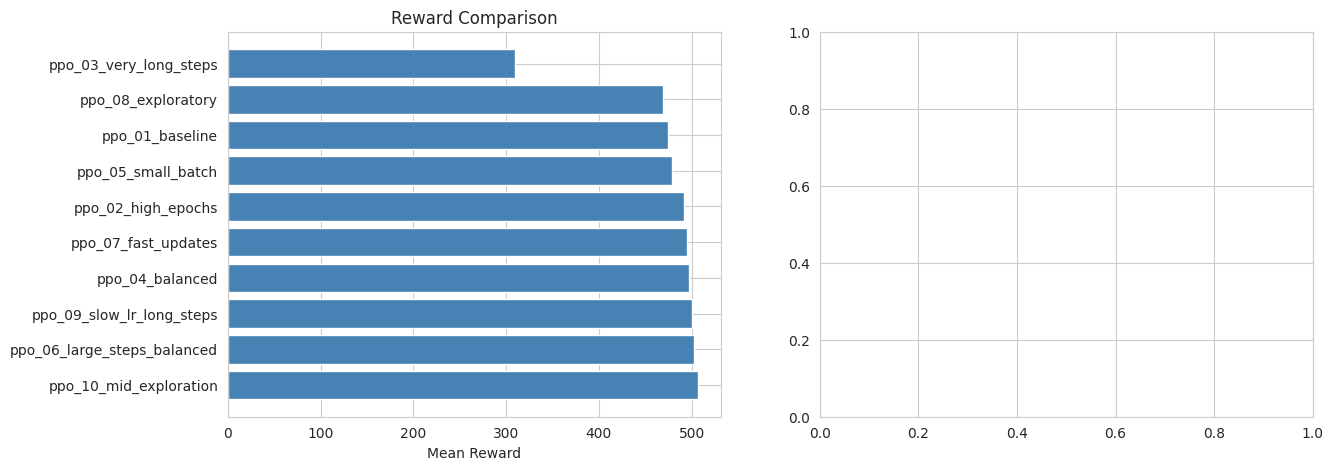

In [ ]:
# Create results dataframe
sweep_df = pd.DataFrame(sweep_results)

# Save sweep results
sweep_csv_path = f"{PROJECT_DIR}/results/ppo_sweep_results.csv"
save_results_to_csv(sweep_results, sweep_csv_path)

# Display sorted results
print("\n" + "="*60)
print("SWEEP RESULTS (sorted by mean reward)")
print("="*60)
print(sweep_df.sort_values('mean_reward', ascending=False)[
    ['config_id', 'mean_reward', 'triage_accuracy', 'training_time_sec']
].to_string(index=False))
print("="*60)

# Plot comparison
plot_config_comparison(
    sweep_df,
    save_path=f"{PROJECT_DIR}/plots/ppo_sweep_comparison.png"
)

# Identify best config
best_config_id = sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'config_id']
best_config = next(c for c in configs if c['id'] == best_config_id)

print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
print(f"   Mean Reward: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'mean_reward']:.2f}")
print(f"   Triage Accuracy: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'triage_accuracy']:.1f}%")
print(f"\n   Hyperparameters:")
for key in ['learning_rate', 'gamma', 'batch_size']:
    print(f"     {key}: {best_config[key]}")
